Инспирировано https://m.habr.com/ru/company/wunderfund/blog/314242/

In [1]:
%tensorflow_version 2.x
%matplotlib inline

In [2]:
import os
import numpy as np

import tensorflow as tf
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import math
import logging
logging.getLogger('tensorflow').setLevel(logging.WARNING)

# tf.enable_eager_execution()

print("TensorFlow v", tf.version.VERSION)

TensorFlow v 2.8.2


Зададим входные данные. `X` — два столбца ($x, y$) по 450 случайных значений. `V` — требуемое значение на выходе нейронной сети.

In [3]:
# input data

np.random.seed(1)
A = (np.random.random((1000, 2)) * 4.0 - 2.0).astype(np.float32)
V = [np.float32((math.fabs(y) + 2*math.fabs(x)<=2) and (x *x + y*y >= 0.5))  for (x, y) in A]

Наймём учителя. Не сами будем учить, а с привлечением внешней помощи в пределах бесплатной квоты Google Colab. У них есть TPU, которые очень быстро научат нашу сеть (когда-нибудь =)), или GPU, которые тоже научат её довольно быстро (сейчас =)).

In [4]:
if len(tensorflow.test.gpu_device_name()):  # GPU
    mode = 'GPU'
elif False:  # TPU https://stackoverflow.com/a/55686370 — пока не готовы
    mode = 'TPU'
else:
    mode = 'CPU'

print("Mode:", mode)
# mode = 'CPU'

logging.getLogger('tensorflow').setLevel(logging.INFO)
if mode == 'GPU':
    strategy = tensorflow.distribute.MirroredStrategy(
        devices=[tensorflow.test.gpu_device_name()]
    )
elif mode == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_host(resolver.master())
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:  # mode == 'CPU'
      strategy = tensorflow.distribute.MirroredStrategy(devices=['CPU'])

logging.getLogger('tensorflow').setLevel(logging.WARNING)
print(f"Strategy is {strategy}.")

Mode: GPU
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Strategy is <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fe56c513310>.


Сконструируем сеть

In [5]:
with strategy.scope() as scope:
    model = tf.keras.Sequential([
        Input(2),
        Dense(18, activation='sigmoid', use_bias=True),
        Dense(1, activation='sigmoid', use_bias=False)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.mean_squared_error,
        metrics='accuracy'
    )
    print("Scope:", scope)

Scope: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fe56c513310>


Научим сеть нуже наконец

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((
  tf.constant(A, dtype=tf.float32),
  tf.constant(V, dtype=tf.float32)
)).shuffle(len(A) * 2, reshuffle_each_iteration=True).batch(1000).repeat()

In [7]:
if os.path.isfile("smart_colab_duckling.h5"):
    model.load_weights("smart_colab_duckling.h5")
    print("Сеть уже была научена раньше.")
else:
    print("Учим сеть...")
    model.fit(\
        dataset, \
        epochs=10, \
        steps_per_epoch=4000 \
      )

    print("Научили сеть. Схороним.")
    model.save_weights("smart_colab_duckling.h5")

Учим сеть...
Epoch 1/10
4000/4000 [==============================] - 34s 7ms/step - loss: 0.1314 - accuracy: 0.8357
Epoch 2/10
4000/4000 [==============================] - 15s 4ms/step - loss: 0.0934 - accuracy: 0.8628
Epoch 3/10
4000/4000 [==============================] - 15s 4ms/step - loss: 0.0566 - accuracy: 0.9295
Epoch 4/10
4000/4000 [==============================] - 15s 4ms/step - loss: 0.0209 - accuracy: 0.9844
Epoch 5/10
4000/4000 [==============================] - 15s 4ms/step - loss: 0.0093 - accuracy: 0.9924
Epoch 6/10
4000/4000 [==============================] - 15s 4ms/step - loss: 0.0045 - accuracy: 0.9962
Epoch 7/10
4000/4000 [==============================] - 17s 4ms/step - loss: 0.0024 - accuracy: 0.9990
Epoch 8/10
4000/4000 [==============================] - 16s 4ms/step - loss: 0.0014 - accuracy: 0.9990
Epoch 9/10
4000/4000 [==============================] - 15s 4ms/step - loss: 8.9152e-04 - accuracy: 0.9990
Epoch 10/10
4000/4000 [==============================] -

Ну и теперь посмотрим, как оно научилось ограничивать круг...

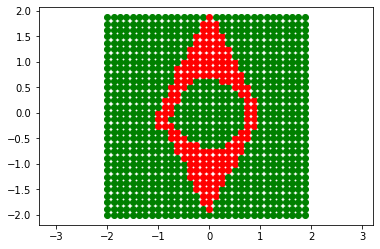

In [12]:
import matplotlib.pyplot as plt

plt.axis('equal')

c = np.r_[-2:2:0.125]

# https://stackoverflow.com/a/11144716/539470 =)
XY = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])

Z = model.predict(XY)

for (x, y), z in zip(XY, Z):
    plt.scatter(x, y, c='red' if z > 0.025 else 'green')

plt.show()

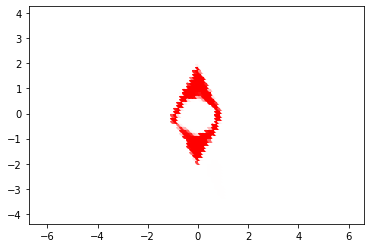

In [9]:
plt.axis('equal')

def saturate(v):
    return min(1, max(0, v))

for (x, y), z in zip(XY, Z):
    plt.scatter(x, y, color=[(1, 1-saturate(z[0]), 1-saturate(z[0]))])

plt.show()